In [7]:
# This code serves as a guide for replication and further development of PINNs, consequently its hevily commented and explained.
# This code stems from various sources, along the code it will be commented in detail and the sources from which the code stems or is used will be listed
# I was heavily directed by Kaggle´s Neural Network Structure due to their courses on Machine Learning and to implementation of PINNs in https://github.com/jdtoscano94/Learning-Scientific_Machine_Learning_Residual_Based_Attention_PINNs_PIKANs_DeepONets/blob/main/Tutorials/PINNs/2_SimpleODE.ipynb
# therefore many parts of the code will be equal or analogous to their structure and notation of the construction of Neural Networks
# which tend to be a standard form of model construction, this will be marked as (Standard). This code uses other sources or open code and
# it will be explained along the code, finally, artificial intelligence has been used for debugging and optimization of the performace of the code.
# Many things are not explicitely explained here, check example 1M1S

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from scipy.integrate import solve_ivp

m = 1
k1 = 2
k2 = 2
k3 = 2

# Generate data
def two_mass(t, y):
    x1, v1, x2, v2 = y
    dx1dt = v1
    dv1dt = (-k1* x1+ k2 *(x2-x1)) /m
    dx2dt = v2
    dv2dt = (-k3* x2- k2*(x2 - x1)) /m
    return [dx1dt, dv1dt, dx2dt, dv2dt]

# Initial conditions
y0 = [0.8, 0.0, -1.1, 0.0]
t_span = (0, 10)
t_eval = np.linspace(*t_span, 200)
sol = solve_ivp(two_mass, t_span, y0, t_eval=t_eval)

t_data_all = sol.t.reshape(-1, 1)
x_data_all = np.vstack((sol.y[0], sol.y[2])).T



# Training data
train_x = np.linspace(0, 199, 20, dtype=int)
t_data = t_data_all[train_x]
x_data = x_data_all[train_x]


# Sin activation for PINN, suggested by chatgpt for faster run of the model, as the solution of the PINN has a similar form
def sin_activation(x):
    return tf.sin(x)

# Definition of PINN (Standard)
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.denses = [layers.Dense(80, activation=sin_activation) for _ in range(3)]
        self.outer = layers.Dense(2, activation=None)

    def call(self, t):
        x = t
        for dense in self.denses:
            x = dense(x)
        return self.outer(x)


# Loss function
def loss_function(model, t, t_data, x_data):
    t = tf.convert_to_tensor(t, dtype=tf.float32)

    # Obtain derivatives
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(t)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(t)
            x = model(t)
            x1 = x[:, 0:1]
            x2 = x[:, 1:2]
        dx1_dt = tape1.gradient(x1, t)
        dx2_dt = tape1.gradient(x2, t)
    d2x1_dt2 = tape2.gradient(dx1_dt, t)
    d2x2_dt2 = tape2.gradient(dx2_dt, t)

    # Differential equation Loss
    eq1 = m * d2x1_dt2 + k1 * x1 - k2 * (x2 - x1)
    eq2 = m * d2x2_dt2 + k3 * x2 + k2 * (x2 - x1)
    loss_PDE = tf.reduce_mean(tf.square(eq1)) + tf.reduce_mean(tf.square(eq2))

    # Initial conditions loss
    t0 = tf.convert_to_tensor([[0.0]], dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape0:
        tape0.watch(t0)
        x0 = model(t0)
        x1_0 = x0[:, 0:1]
        x2_0 = x0[:, 1:2]
    dx1_0 = tape0.gradient(x1_0, t0)
    dx2_0 = tape0.gradient(x2_0, t0)
    loss_IC =  tf.reduce_mean(tf.square(x1_0 - 0.8)) + tf.reduce_mean(tf.square(dx1_0)) + tf.reduce_mean(tf.square(x2_0 + 1.1)) + tf.reduce_mean(tf.square(dx2_0))

    # Data loss
    t_data = tf.convert_to_tensor(t_data, dtype=tf.float32)
    x_data = tf.convert_to_tensor(x_data, dtype=tf.float32)
    x_pred = model(t_data)
    loss_data = tf.reduce_mean(tf.square(x_pred - x_data))



    return loss_PDE + loss_IC + loss_data

# Training of PINN (Standard)
t_train = np.linspace(0, 10, 200).reshape(-1, 1)
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

#Same as 1M1S
for epoch in range(5000):
    with tf.GradientTape() as tape:
        loss = loss_function(model, t_train, t_data, x_data)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

#este1

Epoch 0, Loss: [[2.713841]]
Epoch 100, Loss: [[0.9642668]]
Epoch 200, Loss: [[0.80485225]]
Epoch 300, Loss: [[0.7379853]]
Epoch 400, Loss: [[0.65625155]]
Epoch 500, Loss: [[0.567528]]
Epoch 600, Loss: [[0.5127781]]
Epoch 700, Loss: [[0.48544198]]
Epoch 800, Loss: [[0.45589244]]
Epoch 900, Loss: [[0.37851608]]
Epoch 1000, Loss: [[0.3368501]]
Epoch 1100, Loss: [[0.2215252]]
Epoch 1200, Loss: [[0.40510154]]
Epoch 1300, Loss: [[0.08009419]]
Epoch 1400, Loss: [[0.06203471]]
Epoch 1500, Loss: [[0.03550284]]
Epoch 1600, Loss: [[0.00707217]]
Epoch 1700, Loss: [[0.00526362]]
Epoch 1800, Loss: [[0.00310961]]
Epoch 1900, Loss: [[0.00346338]]
Epoch 2000, Loss: [[0.00225423]]
Epoch 2100, Loss: [[0.0032889]]
Epoch 2200, Loss: [[0.00193811]]
Epoch 2300, Loss: [[0.0174643]]
Epoch 2400, Loss: [[0.00185874]]
Epoch 2500, Loss: [[0.00322172]]
Epoch 2600, Loss: [[0.0017613]]
Epoch 2700, Loss: [[0.0015887]]
Epoch 2800, Loss: [[0.00154463]]
Epoch 2900, Loss: [[0.00144714]]
Epoch 3000, Loss: [[0.01005755]]
Ep

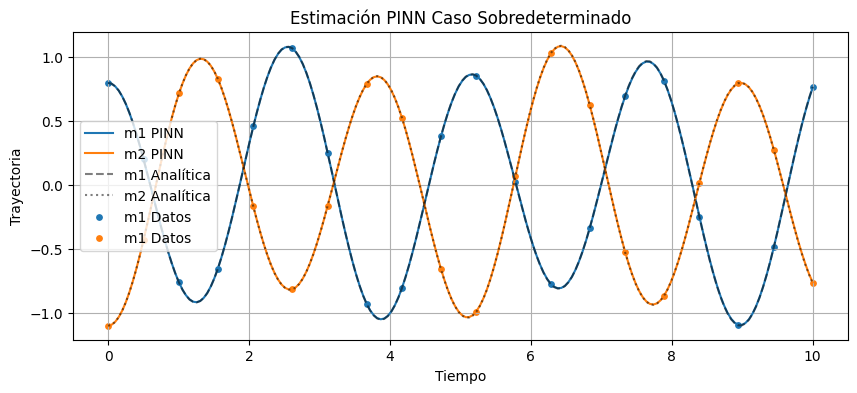

In [8]:

# Graph (Standard)

t_plot = tf.convert_to_tensor(t_train, dtype=tf.float32)
x_pred = model(t_plot).numpy()

plt.figure(figsize=(10, 4))
plt.plot(t_train, x_pred[:, 0], label="m1 PINN")
plt.plot(t_train, x_pred[:, 1],  label="m2 PINN")

plt.plot(t_data_all, x_data_all[:, 0], 'k--', alpha=0.5, label="m1 Analítica")
plt.plot(t_data_all, x_data_all[:, 1], 'k:', alpha=0.5, label="m2 Analítica")

plt.scatter(t_data, x_data[:, 0],  label="m1 Datos", s=15)
plt.scatter(t_data, x_data[:, 1],  label="m1 Datos", s=15)

plt.xlabel("Tiempo")
plt.ylabel("Trayectoria")
plt.legend()
plt.grid(True)
plt.title("Estimación PINN Caso Sobredeterminado")
plt.show()
